**심층 신경망 훈련하기**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

# 깔끔한 그래프 출력을 위해
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 그레이디언트 소실과 폭주 문제

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

그림 저장: sigmoid_saturation_plot


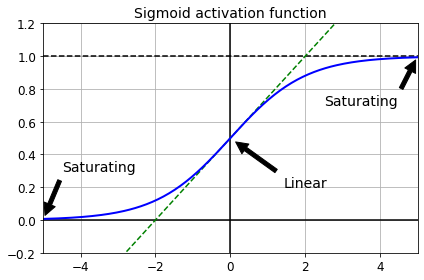

In [3]:
import numpy as np

z = np.linspace(-5, 5, 200)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, 1.2], "k-")
plt.plot([-5, 5], [-3 / 4, 7 / 4], "g--")
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor="black", shrink=0.1)
plt.annotate("Saturating", xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate("Saturating", xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate("Linear", xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier 초기화와 He 초기화

In [4]:
from tensorflow import keras

[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## 수렴하지 않는 활성화 함수

### LeakyReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

그림 저장: leaky_relu_plot


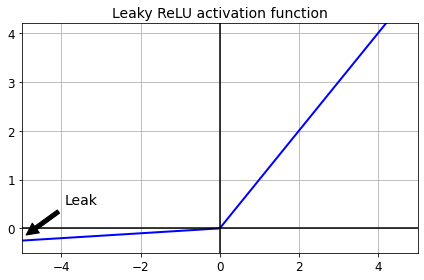

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([0, 0], [-0.5, 4.2], "k-")
plt.grid(True)
props = dict(facecolor="black", shrink=0.1)
plt.annotate("Leak", xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련해 본다:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, kernel_initializer="he_normal"),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(100, kernel_initializer="he_normal"),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [13]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [14]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 1.3178 - accuracy: 0.6004 - val_loss: 0.9052 - val_accuracy: 0.7108
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8145 - accuracy: 0.7294 - val_loss: 0.7244 - val_accuracy: 0.7578
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6955 - accuracy: 0.7686 - val_loss: 0.6457 - val_accuracy: 0.7868
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6329 - accuracy: 0.7905 - val_loss: 0.5957 - val_accuracy: 0.8018
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5927 - accuracy: 0.8018 - val_loss: 0.5664 - val_accuracy: 0.8148
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5645 - accuracy: 0.8102 - val_loss: 0.5419 - val_accuracy: 0.8198
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5436 - accuracy: 0.8156 - val_loss: 0.5233 - val_accuracy:

PReLU를 테스트해 본다:

In [15]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(100, kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [16]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [17]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.2931 - accuracy: 0.6147 - val_loss: 0.8759 - val_accuracy: 0.7328
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7892 - accuracy: 0.7521 - val_loss: 0.7030 - val_accuracy: 0.7852
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6735 - accuracy: 0.7864 - val_loss: 0.6226 - val_accuracy: 0.8072
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6132 - accuracy: 0.8017 - val_loss: 0.5750 - val_accuracy: 0.8212
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5743 - accuracy: 0.8110 - val_loss: 0.5428 - val_accuracy: 0.8300
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5468 - accuracy: 0.8190 - val_loss: 0.5229 - val_accuracy: 0.8328
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5261 - accuracy: 0.8237 - val_loss: 0.5036 - val_accuracy:

### ELU

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


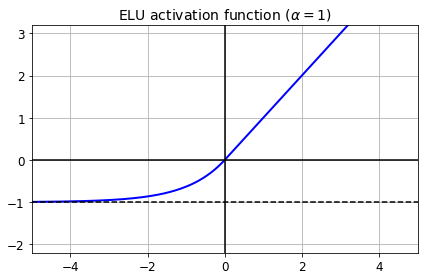

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [-1, -1], "k--")
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
save_fig("elu_plot")
plt.show()

텐서플로에서 쉽게 ELU를 적용할 수 있다. 층을 만들 때 활성화 함수로 지정하면 된다:

In [20]:
keras.layers.Dense(10, activation="elu")

### SELU

Günter Klambauer, Thomas Unterthiner, Andreas Mayr는 2017년 한 [훌륭한 논문](https://arxiv.org/pdf/1706.02515.pdf)에서 SELU 활성화 함수를 소개했다. 훈련하는 동안 완전 연결 층만 쌓아서 신경망을 만들고 SELU 활성화 함수와 LeCun 초기화를 사용한다면 자기 정규화된다. 각 층의 출력이 평균과
표준편차를 보존하는 경향이 있다. 이는 그레이디언트 소실과 폭주 문제를 막아 준다. 그 결과로 SELU 활성화 함수는 이런 종류의 네트워크(특히 아주 깊은 네트워크)에서 다른 활성화 함수보다 뛰어난 성능을 종종 낸다. 따라서 꼭 시도해 봐야 한다. 하지만 SELU 활성화 함수의 자기 정규화 특징은 쉽게 깨진다. ℓ<sub>1</sub>나 ℓ<sub>2</sub> 정규화, 드롭아웃, 맥스 노름, 스킵 연결이나 시퀀셜하지 않은 다른 토폴로지를 사용할 수 없다(즉 순환 신경망은 자기 정규화되지 않는다). 하지만 실전에서 시퀀셜 CNN과 잘 동작한다. 자기 정규화가 깨지면 SELU가 다른 활성화 함수보다 더 나은 성능을 내지 않을 것이다.

In [21]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화한다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (
        2 * erfc(np.sqrt(2)) * np.e ** 2 + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e - 2 * (2 + np.pi) * erfc(
    1 / np.sqrt(2)) * np.sqrt(np.e) + np.pi + 2) ** (-1 / 2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


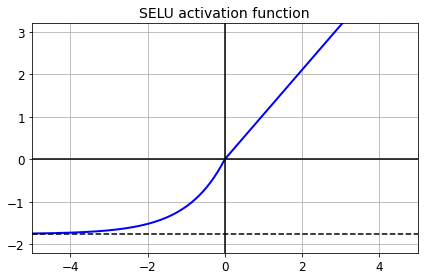

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [-1.758, -1.758], "k--")
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
save_fig("selu_plot")
plt.show()

기본적으로 SELU 하이퍼파라미터(`scale`과 `alpha`)는 각 뉴런의 평균 출력이 0에 가깝고 표준 편차는 1에 가깝도록 조정된다(입력은 평균이 0이고 표준 편차 1로 표준화되었다고 가정한다). 이 활성화 함수를 사용하면 1,000개의 층이 있는 심층 신경망도 모든 층에 걸쳐 거의 평균이 0이고 표준 편차를 1로 유지한다. 이를 통해 그레이디언트 폭주와 소실 문제를 피할 수 있다:

In [24]:
Z = np.random.normal(size=(500, 100))  # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100))  # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print(f"Layer {layer}: mean {means:.2f}, std deviation {stds:.2f}")

Layer 0: mean 0.00, std deviation 1.00
Layer 100: mean -0.01, std deviation 0.90
Layer 200: mean 0.02, std deviation 0.93
Layer 300: mean 0.06, std deviation 0.88
Layer 400: mean -0.05, std deviation 0.90
Layer 500: mean 0.02, std deviation 0.92
Layer 600: mean -0.04, std deviation 0.96
Layer 700: mean -0.00, std deviation 0.92
Layer 800: mean 0.09, std deviation 0.90
Layer 900: mean 0.03, std deviation 0.92


쉽게 SELU를 사용할 수 있다:

In [25]:
keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

100개의 은닉층과 SELU 활성화 함수를 사용한 패션 MNIST를 위한 신경망을 만들어 본다:

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [27]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

이제 훈련해 본다. 입력을 평균 0과 표준 편차 1로 바꾸어야 한다는 것을 잊지 않는다:

In [28]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [29]:
history = model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 48s 27ms/step - loss: 1.2700 - accuracy: 0.5081 - val_loss: 0.9349 - val_accuracy: 0.6610
Epoch 2/5
1719/1719 [==============================] - 45s 26ms/step - loss: 0.9094 - accuracy: 0.6589 - val_loss: 0.8346 - val_accuracy: 0.6782
Epoch 3/5
1719/1719 [==============================] - 45s 26ms/step - loss: 1.0410 - accuracy: 0.6072 - val_loss: 1.2108 - val_accuracy: 0.4876
Epoch 4/5
1719/1719 [==============================] - 45s 26ms/step - loss: 1.0841 - accuracy: 0.5781 - val_loss: 1.0609 - val_accuracy: 0.6114
Epoch 5/5
1719/1719 [==============================] - 45s 26ms/step - loss: 0.8325 - accuracy: 0.6878 - val_loss: 0.6902 - val_accuracy: 0.7474


대신 ReLU 활성화 함수를 사용하면 어떤 일이 일어나는지 확인해 본다:

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [31]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [32]:
history = model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 50s 28ms/step - loss: 2.0046 - accuracy: 0.2266 - val_loss: 1.8461 - val_accuracy: 0.3096
Epoch 2/5
1719/1719 [==============================] - 45s 26ms/step - loss: 1.5387 - accuracy: 0.3829 - val_loss: 1.1158 - val_accuracy: 0.5374
Epoch 3/5
1719/1719 [==============================] - 44s 26ms/step - loss: 1.1698 - accuracy: 0.5306 - val_loss: 1.1211 - val_accuracy: 0.5550
Epoch 4/5
1719/1719 [==============================] - 47s 27ms/step - loss: 1.0092 - accuracy: 0.6233 - val_loss: 0.8602 - val_accuracy: 0.7122
Epoch 5/5
1719/1719 [==============================] - 46s 27ms/step - loss: 1.0479 - accuracy: 0.6099 - val_loss: 0.8386 - val_accuracy: 0.7156


좋지 않다. 그레이디언트 폭주나 소실 문제가 발생한 것이다.

# 배치 정규화

In [33]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [35]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [36]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [37]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8556 - accuracy: 0.7124 - val_loss: 0.5626 - val_accuracy: 0.8080
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5802 - accuracy: 0.8007 - val_loss: 0.4817 - val_accuracy: 0.8390
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5163 - accuracy: 0.8219 - val_loss: 0.4467 - val_accuracy: 0.8500
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4854 - accuracy: 0.8319 - val_loss: 0.4247 - val_accuracy: 0.8572
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4564 - accuracy: 0.8392 - val_loss: 0.4083 - val_accuracy: 0.8592
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4408 - accuracy: 0.8458 - val_loss: 0.3933 - val_accuracy: 0.8654
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4237 - accuracy: 0.8509 - val_loss: 0.3859 - val_ac

이따금 활성화 함수 전에 BN을 적용해도 잘 동작한다(여기에는 논란의 여지가 있다). 또한 `BatchNormalization` 층 이전의 층은 편향을 위한 항이 필요 없다. `BatchNormalization` 층이 이를 무효화하기 때문이다. 따라서 필요 없는 파라미터이므로 `use_bias=False`를 지정하여 층을 만들 수 있다:

In [38]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dense(100, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [39]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [40]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 1.0499 - accuracy: 0.6672 - val_loss: 0.6726 - val_accuracy: 0.7844
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6765 - accuracy: 0.7811 - val_loss: 0.5577 - val_accuracy: 0.8176
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5918 - accuracy: 0.8033 - val_loss: 0.5004 - val_accuracy: 0.8334
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5438 - accuracy: 0.8169 - val_loss: 0.4677 - val_accuracy: 0.8398
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5138 - accuracy: 0.8257 - val_loss: 0.4444 - val_accuracy: 0.8480
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4863 - accuracy: 0.8334 - val_loss: 0.4273 - val_accuracy: 0.8532
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4721 - accuracy: 0.8370 - val_loss: 0.4145 - val_ac

## 그레이디언트 클리핑

모든 케라스 옵티마이저는 `clipnorm`이나 `clipvalue` 매개변수를 지원한다:

In [41]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [42]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 사전 훈련된 층 재사용하기

### 케라스 모델 재사용하기

패션 MNIST 훈련 세트를 두 개로 나누어 본다:
* `X_train_A`: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* `X_train_B`: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

검증 세트와 테스트 세트도 이렇게 나눈다. 하지만 이미지 개수는 제한하지 않는다.

A 세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B 세트(이진 분류)를 해결해 본다. A 작업에서 B 작업으로 약간의 지식이 전달되기를 기대한다. 왜냐하면 A 세트의 클래스(스니커즈, 앵클 부츠, 코트, 티셔츠 등)가 B 세트에 있는 클래스(샌달과 셔츠)와 조금 비슷하기 때문이다. 하지만 `Dense` 층을 사용하기 때문에 동일한 위치에 나타난 패턴만 재사용할 수 있다(반대로 합성곱 층은 훨씬 많은 정보를 전송한다. 학습한 패턴을 이미지의 어느 위치에서나 감지할 수 있기 때문이다.).

In [43]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6)  # 샌들 또는 셔츠
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2  # 클래스 인덱스 7, 8, 9는 5, 6, 7로 이동해야 한다
    y_B = (y[y_5_or_6] == 6).astype(np.float32)  # 이진 분류 작업: 셔츠(클래스 6)인가?
    return (X[~y_5_or_6], y_A), (X[y_5_or_6], y_B)


(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [44]:
X_train_A.shape

(43986, 28, 28)

In [45]:
X_train_B.shape

(200, 28, 28)

In [46]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [47]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [48]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [49]:
model_A.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [50]:
history = model_A.fit(X_train_A, y_train_A, epochs=20, validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.5669 - accuracy: 0.8204 - val_loss: 0.3709 - val_accuracy: 0.8742
Epoch 2/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3517 - accuracy: 0.8813 - val_loss: 0.3219 - val_accuracy: 0.8906
Epoch 3/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3164 - accuracy: 0.8933 - val_loss: 0.2997 - val_accuracy: 0.8986
Epoch 4/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2974 - accuracy: 0.8993 - val_loss: 0.2900 - val_accuracy: 0.8994
Epoch 5/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2849 - accuracy: 0.9035 - val_loss: 0.2773 - val_accuracy: 0.9056
Epoch 6/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2759 - accuracy: 0.9067 - val_loss: 0.2726 - val_accuracy: 0.9076
Epoch 7/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2682 - accuracy: 0.9097 - val_loss: 0.2657 - val_accuracy:

In [51]:
model_A.save("my_model_A.h5")

In [52]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [53]:
model_B.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"])

In [54]:
history = model_B.fit(X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 43ms/step - loss: 0.7542 - accuracy: 0.4800 - val_loss: 0.6148 - val_accuracy: 0.6633
Epoch 2/20
7/7 [==============================] - 0s 20ms/step - loss: 0.5741 - accuracy: 0.6600 - val_loss: 0.4944 - val_accuracy: 0.7465
Epoch 3/20
7/7 [==============================] - 0s 19ms/step - loss: 0.4564 - accuracy: 0.8000 - val_loss: 0.4038 - val_accuracy: 0.8540
Epoch 4/20
7/7 [==============================] - 0s 19ms/step - loss: 0.3702 - accuracy: 0.8850 - val_loss: 0.3439 - val_accuracy: 0.8955
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 0.3120 - accuracy: 0.9050 - val_loss: 0.3003 - val_accuracy: 0.9209
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 0.2692 - accuracy: 0.9350 - val_loss: 0.2669 - val_accuracy: 0.9280
Epoch 7/20
7/7 [==============================] - 0s 20ms/step - loss: 0.2359 - accuracy: 0.9600 - val_loss: 0.2430 - val_accuracy: 0.9331
Epoch 8/20
7/7 [===========

In [55]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_224 (Dense)           (None, 300)               235500    
                                                                 
 dense_225 (Dense)           (None, 100)               30100     
                                                                 
 dense_226 (Dense)           (None, 50)                5050      
                                                                 
 dense_227 (Dense)           (None, 50)                2550      
                                                                 
 dense_228 (Dense)           (None, 50)                2550      
                                                                 
 dense_229 (Dense)           (None, 1)                

In [56]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

`model_B_on_A`와 `model_A`는 층을 공유하기 때문에 하나를 훈련하면 두 모델이 업데이트된다. 이를 피하려면 `model_A`를 클론한 것을 사용해 `model_B_on_A`를 만들어야 한다:

In [57]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [58]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [59]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B))
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 41ms/step - loss: 1.7676 - accuracy: 0.2550 - val_loss: 1.6629 - val_accuracy: 0.3053
Epoch 2/4
7/7 [==============================] - 0s 19ms/step - loss: 1.6710 - accuracy: 0.2750 - val_loss: 1.5721 - val_accuracy: 0.3316
Epoch 3/4
7/7 [==============================] - 0s 19ms/step - loss: 1.5757 - accuracy: 0.2850 - val_loss: 1.4887 - val_accuracy: 0.3428
Epoch 4/4
7/7 [==============================] - 0s 18ms/step - loss: 1.4884 - accuracy: 0.2950 - val_loss: 1.4108 - val_accuracy: 0.3570
Epoch 1/16
7/7 [==============================] - 1s 42ms/step - loss: 1.1134 - accuracy: 0.4300 - val_loss: 0.7135 - val_accuracy: 0.5822
Epoch 2/16
7/7 [==============================] - 0s 22ms/step - loss: 0.6018 - accuracy: 0.6900 - val_loss: 0.4458 - val_accuracy: 0.7870
Epoch 3/16
7/7 [==============================] - 0s 23ms/step - loss: 0.3822 - accuracy: 0.8300 - val_loss: 0.3014 - val_accuracy: 0.8884
Epoch 4/16
7/7 [===============

마지막 점수는 어떨까?

In [60]:
B = model_B.evaluate(X_test_B, y_test_B)
B

63/63 [==============================] - 0s 2ms/step - loss: 0.1184 - accuracy: 0.9785


[0.11841949820518494, 0.9785000085830688]

In [61]:
B_on_A = model_B_on_A.evaluate(X_test_B, y_test_B)
B_on_A

63/63 [==============================] - 0s 2ms/step - loss: 0.0656 - accuracy: 0.9895


[0.065567746758461, 0.9894999861717224]

아주 약간의 정보를 전달했다: 오차율이 아주 조금 줄었다.

In [62]:
(100 - B[1]) / (100 - B_on_A[1])

1.0001110991014803

# 고속 옵티마이저

## 모멘텀 옵티마이저

In [63]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## 네스테로프 가속 경사

In [64]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [65]:
optimizer = keras.optimizers.Adagrad()

## RMSProp

In [66]:
optimizer = keras.optimizers.RMSprop()

## Adam 옵티마이저

In [67]:
optimizer = keras.optimizers.Adam()

## Nadam 옵티마이저

In [68]:
optimizer = keras.optimizers.Nadam()

## 학습률 스케줄링

### 거듭제곱 스케줄링

```lr = lr0 / (1 + steps / s)**c```
* 케라스는 `c=1`과 `s = 1 / decay`을 사용한다

In [69]:
optimizer = keras.optimizers.SGD(decay=1e-4)

In [70]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [71]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4860 - accuracy: 0.8281 - val_loss: 0.4170 - val_accuracy: 0.8548
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3782 - accuracy: 0.8661 - val_loss: 0.3785 - val_accuracy: 0.8692
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3454 - accuracy: 0.8780 - val_loss: 0.3624 - val_accuracy: 0.8728
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3239 - accuracy: 0.8852 - val_loss: 0.3537 - val_accuracy: 0.8786
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3080 - accuracy: 0.8897 - val_loss: 0.3535 - val_accuracy: 0.8742
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2959 - accuracy: 0.8941 - val_loss: 0.3417 - val_accuracy: 0.8798
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2855 - accuracy: 0.8983 - val_loss: 0.3360 - val_accuracy:

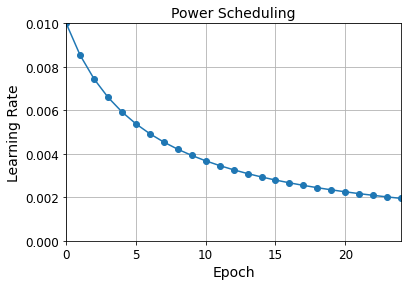

In [72]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)
plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 지수 기반 스케줄링

```lr = lr0 * 0.1**(epoch / s)```

In [73]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [74]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [75]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [76]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(
    X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[lr_scheduler]
)

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8726 - accuracy: 0.7497 - val_loss: 0.8406 - val_accuracy: 0.7824 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6878 - accuracy: 0.7928 - val_loss: 0.5733 - val_accuracy: 0.8194 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6135 - accuracy: 0.8154 - val_loss: 0.5701 - val_accuracy: 0.8436 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5456 - accuracy: 0.8387 - val_loss: 0.6605 - val_accuracy: 0.8478 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5110 - accuracy: 0.8500 - val_loss: 0.6270 - val_accuracy: 0.8308 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4599 - accuracy: 0.8631 - val_loss: 0.5522 - val_accuracy: 0.8512 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================

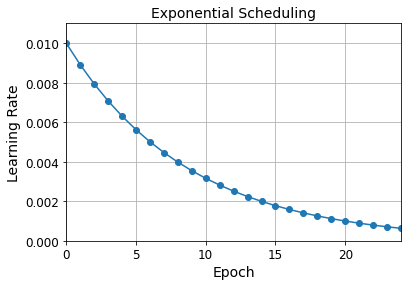

In [77]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

이 스케줄 함수는 두 번째 매개변수로 현재 학습률을 받을 수 있다:

In [78]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

에포크가 아니라 반복마다 학습률을 업데이트하려면 사용자 정의 콜백 클래스를 작성해야 한다:

In [79]:
K = keras.backend


class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 노트: 에포크마다 `batch` 매개변수가 재설정된다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1 ** (1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs["lr"] = K.get_value(self.model.optimizer.lr)


model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
s = 20 * len(X_train) // 32  # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(
    X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[exp_decay]
)

Epoch 1/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7915 - accuracy: 0.7693 - val_loss: 1.0044 - val_accuracy: 0.7438 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.6268 - accuracy: 0.8072 - val_loss: 0.6707 - val_accuracy: 0.7664 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5799 - accuracy: 0.8233 - val_loss: 0.6814 - val_accuracy: 0.7886 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5219 - accuracy: 0.8342 - val_loss: 0.5405 - val_accuracy: 0.8434 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4829 - accuracy: 0.8481 - val_loss: 0.5062 - val_accuracy: 0.8508 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4332 - accuracy: 0.8604 - val_loss: 0.5103 - val_accuracy: 0.8406 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

In [80]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1 ** (steps / s)

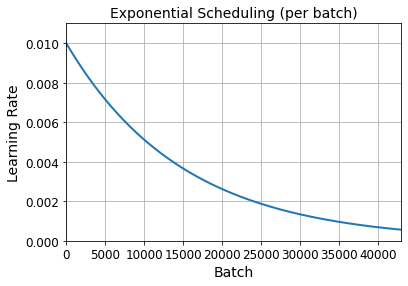

In [81]:
plt.plot(steps, lrs, '-', linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### 기간별 고정 스케줄링

In [82]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [83]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)

    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]

    return piecewise_constant_fn


piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [84]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(
    X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[lr_scheduler]
)

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8484 - accuracy: 0.7536 - val_loss: 0.9064 - val_accuracy: 0.7464 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8038 - accuracy: 0.7627 - val_loss: 0.6594 - val_accuracy: 0.7922 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.9053 - accuracy: 0.7469 - val_loss: 0.6332 - val_accuracy: 0.8086 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8709 - accuracy: 0.7469 - val_loss: 1.0383 - val_accuracy: 0.7252 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.9818 - accuracy: 0.6754 - val_loss: 1.3079 - val_accuracy: 0.4496 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8561 - accuracy: 0.6573 - val_loss: 0.9655 - val_accuracy: 0.6324 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

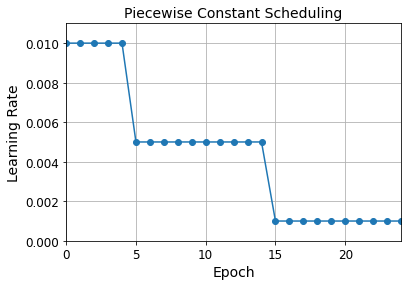

In [85]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [86]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(
    X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[lr_scheduler]
)

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5897 - accuracy: 0.8076 - val_loss: 0.5808 - val_accuracy: 0.8096 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4924 - accuracy: 0.8402 - val_loss: 0.5183 - val_accuracy: 0.8404 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4916 - accuracy: 0.8472 - val_loss: 0.5911 - val_accuracy: 0.8264 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5026 - accuracy: 0.8501 - val_loss: 0.8257 - val_accuracy: 0.8270 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5053 - accuracy: 0.8513 - val_loss: 0.6428 - val_accuracy: 0.8256 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4954 - accuracy: 0.8556 - val_loss: 0.5314 - val_accuracy: 0.8594 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 5s

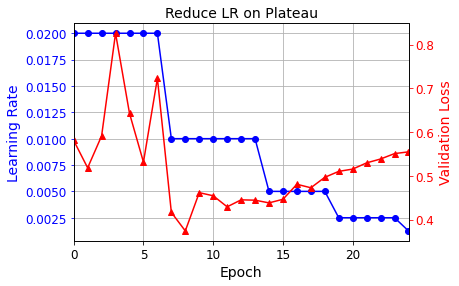

In [87]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)
ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel("Validation Loss", color='r')
ax2.tick_params('y', colors='r')
plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras 스케줄러

In [88]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
s = 20 * len(X_train) // 32  # 20 Epoch의 단계 수 (배치 크기 = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4886 - accuracy: 0.8277 - val_loss: 0.4209 - val_accuracy: 0.8572
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3811 - accuracy: 0.8647 - val_loss: 0.3916 - val_accuracy: 0.8598
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3470 - accuracy: 0.8765 - val_loss: 0.3789 - val_accuracy: 0.8698
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3250 - accuracy: 0.8841 - val_loss: 0.3622 - val_accuracy: 0.8674
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3078 - accuracy: 0.8915 - val_loss: 0.3577 - val_accuracy: 0.8724
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2946 - accuracy: 0.8963 - val_loss: 0.3583 - val_accuracy: 0.8710
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2837 - accuracy: 0.8992 - val_loss: 0.3436 - val_accuracy:

구간별 고정 스케줄링은 다음을 사용한다:

In [89]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch], values=[0.01, 0.005, 0.001]
)

### 1사이클 스케줄링

In [90]:
K = keras.backend


class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)


def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10 ** -5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses


def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale("log")
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**경고**: `on_batch_end()` 메서드에서 `logs["loss"]`로 (에포크의) 평균 손실을 모은다. 이런 이유로 아래 그래프가 부드럽다. 이는 그래프에서 배치 손실이 폭주하기 시작하는 지점과 그렇지 않은 지점 사이에 지연이 있다는 뜻이다. 따라서 변동이 심한 그래프에서는 조금 더 작은 학습률을 선택해야 한다. 또한 `ExponentialLearningRate` 콜백을 조금 바꾸어 (현재 평균 손실과 이전 평균 손실을 기반으로) 배치 손실을 계산할 수 있다:

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.prev_loss = None
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0

    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
```

In [91]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

430/430 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.4133


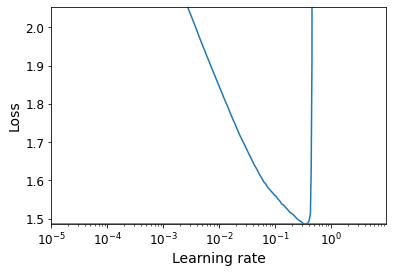

In [92]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [93]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None, last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, rate1, rate2):
        return (rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations, self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [94]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[onecycle]
)

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.6520 - accuracy: 0.7747 - val_loss: 0.4880 - val_accuracy: 0.8374
Epoch 2/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4599 - accuracy: 0.8377 - val_loss: 0.4419 - val_accuracy: 0.8456
Epoch 3/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4142 - accuracy: 0.8536 - val_loss: 0.4057 - val_accuracy: 0.8600
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3843 - accuracy: 0.8634 - val_loss: 0.4007 - val_accuracy: 0.8592
Epoch 5/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3631 - accuracy: 0.8701 - val_loss: 0.3747 - val_accuracy: 0.8692
Epoch 6/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3454 - accuracy: 0.8762 - val_loss: 0.3782 - val_accuracy: 0.8698
Epoch 7/25
430/430 [==============================] - 2s 3ms/step - loss: 0.3302 - accuracy: 0.8810 - val_loss: 0.3650 - val_accuracy: 0.8736
Epoch 

In [95]:
layer = keras.layers.Dense(
    100, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2()
)
# 또는 인수 0.1의 ℓ1 정규화에 대해 l1(0.1)
# 또는 l1_l2(0.1, 0.01) ℓ1 및 ℓ2 정규화에 대해 각각 0.1 및 0.01 인수

In [96]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(
            300, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2()
        ),
        keras.layers.Dense(
            100, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2()
        ),
        keras.layers.Dense(10, activation="softmax", kernel_regularizer=keras.regularizers.l2())
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 1.6396 - accuracy: 0.8117 - val_loss: 0.7248 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7215 - accuracy: 0.8256 - val_loss: 0.7165 - val_accuracy: 0.8226


In [97]:
from functools import partial

RegularizedDense = partial(
    keras.layers.Dense, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2()
)
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        RegularizedDense(300),
        RegularizedDense(100),
        RegularizedDense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 6ms/step - loss: 1.5912 - accuracy: 0.8118 - val_loss: 0.7327 - val_accuracy: 0.8196
Epoch 2/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7150 - accuracy: 0.8283 - val_loss: 0.6910 - val_accuracy: 0.8394


## 드롭아웃

In [98]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5727 - accuracy: 0.8027 - val_loss: 0.3726 - val_accuracy: 0.8590
Epoch 2/2
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4247 - accuracy: 0.8442 - val_loss: 0.3566 - val_accuracy: 0.8714


## 알파 드롭아웃

In [99]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.AlphaDropout(rate=0.2),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.AlphaDropout(rate=0.2),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.AlphaDropout(rate=0.2),
        keras.layers.Dense(10, activation="softmax")
    ]
)
optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6695 - accuracy: 0.7578 - val_loss: 0.7009 - val_accuracy: 0.8280
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5608 - accuracy: 0.7934 - val_loss: 0.5194 - val_accuracy: 0.8438
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5247 - accuracy: 0.8057 - val_loss: 0.5227 - val_accuracy: 0.8522
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5088 - accuracy: 0.8119 - val_loss: 0.5046 - val_accuracy: 0.8502
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4948 - accuracy: 0.8176 - val_loss: 0.5177 - val_accuracy: 0.8512
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4791 - accuracy: 0.8232 - val_loss: 0.4438 - val_accuracy: 0.8688
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4689 - accuracy: 0.8264 - val_loss: 0.4692 - val_accuracy:

In [100]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.5104 - accuracy: 0.8561


[0.5103578567504883, 0.8561000227928162]

In [101]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 4s 2ms/step - loss: 0.3810 - accuracy: 0.8750


[0.38100603222846985, 0.874963641166687]

In [102]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 6s 4ms/step - loss: 0.4161 - accuracy: 0.8453


## MC 드롭아웃

In [103]:
y_probas = np.stack([model(X_test_scaled, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [104]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 99ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99]],
      dtype=float32)

In [105]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.12, 0.  , 0.82]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.44, 0.  , 0.07, 0.  , 0.48]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.19, 0.  , 0.48]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.09, 0.  , 0.77]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.02, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.35, 0.  , 0.37, 0.  , 0.28]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.55, 0.  , 0.02, 0.  , 0.43]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.02, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.  , 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.11, 0.  , 0.83]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0

In [106]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.15, 0.  , 0.7 ]],
      dtype=float32)

In [107]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.17, 0.  , 0.24]],
      dtype=float32)

In [108]:
y_pred = np.argmax(y_proba, axis=1)

In [109]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8621

In [110]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)


class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [111]:
isinstance(model.layers[1], keras.layers.AlphaDropout)

True

In [112]:
mc_model = keras.models.Sequential(
    [MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer for layer in model.layers]
)

In [113]:
mc_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_263 (Dense)           (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_264 (Dense)           (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)            

In [114]:
optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [115]:
mc_model.set_weights(model.get_weights())

이제 MC 드롭아웃을 모델에 사용할 수 있다:

In [116]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 20ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.11, 0.  , 0.7 ]],
      dtype=float32)

## 맥스 노름

In [117]:
layer = keras.layers.Dense(
    100, activation="selu", kernel_initializer="lecun_normal", kernel_constraint=keras.constraints.max_norm(1.)
)

In [118]:
MaxNormDense = partial(
    keras.layers.Dense,
    activation="selu",
    kernel_initializer="lecun_normal",
    kernel_constraint=keras.constraints.max_norm(1.)
)
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        MaxNormDense(300),
        MaxNormDense(100),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4752 - accuracy: 0.8338 - val_loss: 0.3662 - val_accuracy: 0.8734
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3570 - accuracy: 0.8691 - val_loss: 0.3474 - val_accuracy: 0.8770


# 연습

## 1. CIFAR10에서 딥러닝